In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

from tqdm.notebook import tqdm

import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import mean_squared_error, mean_absolute_error

from IMV_LSTM import IMVTensorLSTM

import os
from IPython.utils import io

import time

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning);


Populating the interactive namespace from numpy and matplotlib


D:\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
pl.seed_everything(8);

Global seed set to 8


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize']=12,8

In [4]:
df_og = pd.read_csv('Bike_Sharing_Daily.csv')

data1=df_og.iloc[:-99,:]
data2=df_og.iloc[-99:,:]

data1.drop(columns = 'datetime',inplace = True)
data2.drop(columns = 'datetime',inplace = True)

target = 'total_count'
cols = list(data1.columns)

C:\Users\eduma\AppData\Local\Temp\ipykernel_9860\455810338.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.drop(columns = 'datetime',inplace = True)
C:\Users\eduma\AppData\Local\Temp\ipykernel_9860\455810338.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.drop(columns = 'datetime',inplace = True)


In [5]:
train_size = data1.shape[0]
val_size = 99
depth = 15
batch_size = 15
prediction_horizon = 1

In [6]:
X_train1 = np.zeros((len(data1), depth, len(cols)))
y_train1 = np.zeros((len(data1), 1))

In [7]:
for i, name in enumerate(cols):
    for j in range(depth):
        X_train1[:, j, i] = data1[name].shift(depth - j - 1).fillna(method="bfill")
y_train1 = data1[target].shift(-prediction_horizon).fillna(method='ffill')

In [8]:
X_train1 = X_train1[depth:-prediction_horizon]
y_train1 = y_train1[depth:-prediction_horizon]

In [9]:
X2 = np.zeros((len(data2), depth, len(cols)))
y2 = np.zeros((len(data2), 1))

In [10]:
for i, name in enumerate(cols):
    for j in range(depth):
        X2[:, j, i] = data2[name].shift(depth - j - 1).fillna(method="bfill")
y2 = data2[target].shift(-prediction_horizon).fillna(method='ffill')

In [11]:
X_train2 = X2[:train_size - len(data1)]
y_train2 = y2[:train_size - len(data1)]

X_val = X2[train_size - len(data1):train_size - len(data1) + val_size]
y_val = y2[train_size - len(data1):train_size - len(data1) + val_size]

X_test = X2[train_size - len(data1) + val_size:]
y_test = y2[train_size - len(data1) + val_size:]

In [12]:
X_train2 = X_train2[depth:]
y_train2 = y_train2[depth:]

In [13]:
X_train = np.concatenate([X_train1, X_train2], axis=0)
y_train = np.concatenate([y_train1, y_train2], axis=0)

In [14]:
X_train.shape, y_train.shape
X_val.shape, y_val.shape

((99, 15, 27), (99,))

In [15]:
X_train_min, y_train_min = X_train.min(axis=0), y_train.min(axis=0)
X_train_max, y_train_max = X_train.max(axis=0), y_train.max(axis=0)

In [16]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

In [17]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val.values)
y_test_t = torch.Tensor(y_test.values)

In [18]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=batch_size)

In [41]:
model = IMVTensorLSTM(X_train.shape[2], 1, 64)
opt = torch.optim.Adam(model.parameters(), lr=0.05)

In [42]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

  0%|          | 0/10001 [00:00<?, ?it/s]

Saving...
Iter:  0 train:  0.2068133050771519 val:  0.29452404668891685
Iter time:  3.6089999999967404
mse:  5951368.5 mae:  2154.3037


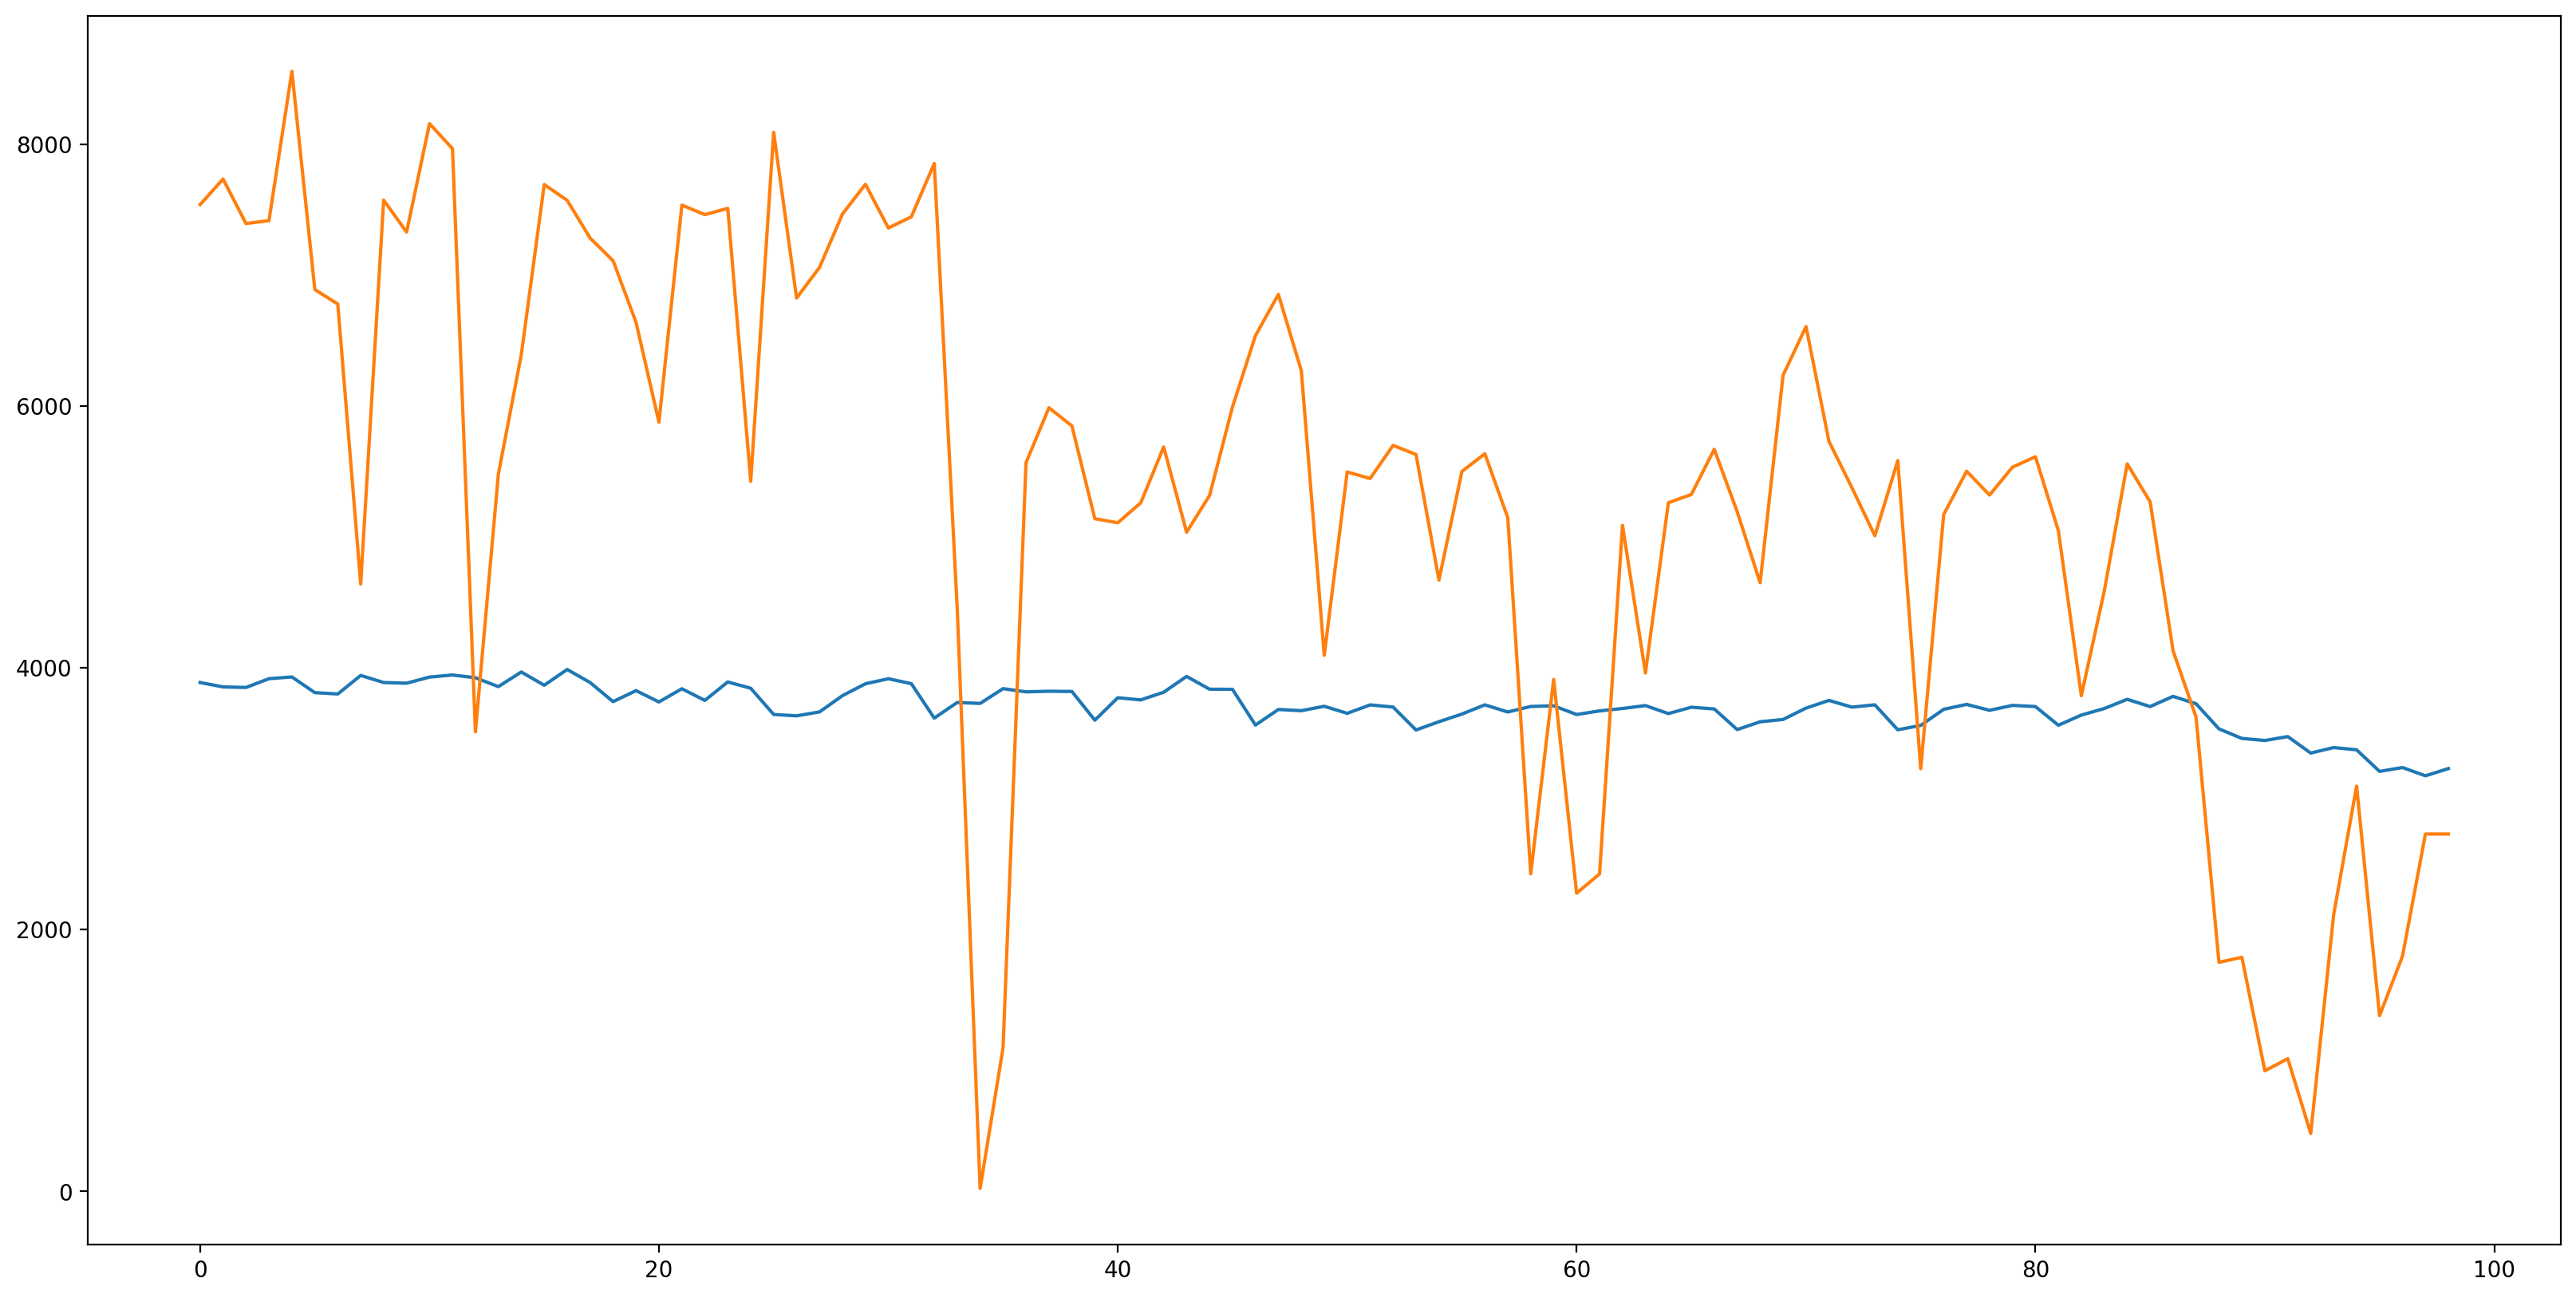

Iter:  1 train:  0.14968058569077985 val:  0.31253808870437016
Iter time:  3.7189999999827705
Saving...
Iter:  2 train:  0.13801086792011438 val:  0.2778604486513775
Iter time:  3.625
Saving...
Iter:  3 train:  0.14011533749462393 val:  0.22823465792341488
Iter time:  4.437000000005355
Saving...
Iter:  4 train:  0.12295127068230587 val:  0.21892541735123405
Iter time:  3.8910000000032596
Iter:  5 train:  0.12198147523244902 val:  0.22550173960516107
Iter time:  3.937999999994645
Iter:  6 train:  0.12396992285736738 val:  0.23447966093155026
Iter time:  3.875
Saving...
Iter:  7 train:  0.11868643067334417 val:  0.21543188145066705
Iter time:  3.937000000005355
Saving...
Iter:  8 train:  0.11490511862789896 val:  0.20676317834285682
Iter time:  3.9689999999827705
Saving...
Iter:  9 train:  0.11911947001726031 val:  0.20109767855842628
Iter time:  5.219000000011874
Iter:  10 train:  0.11612166224717335 val:  0.20341232445252241
Iter time:  4.280999999988126
mse:  2838767.8 mae:  1296.9246

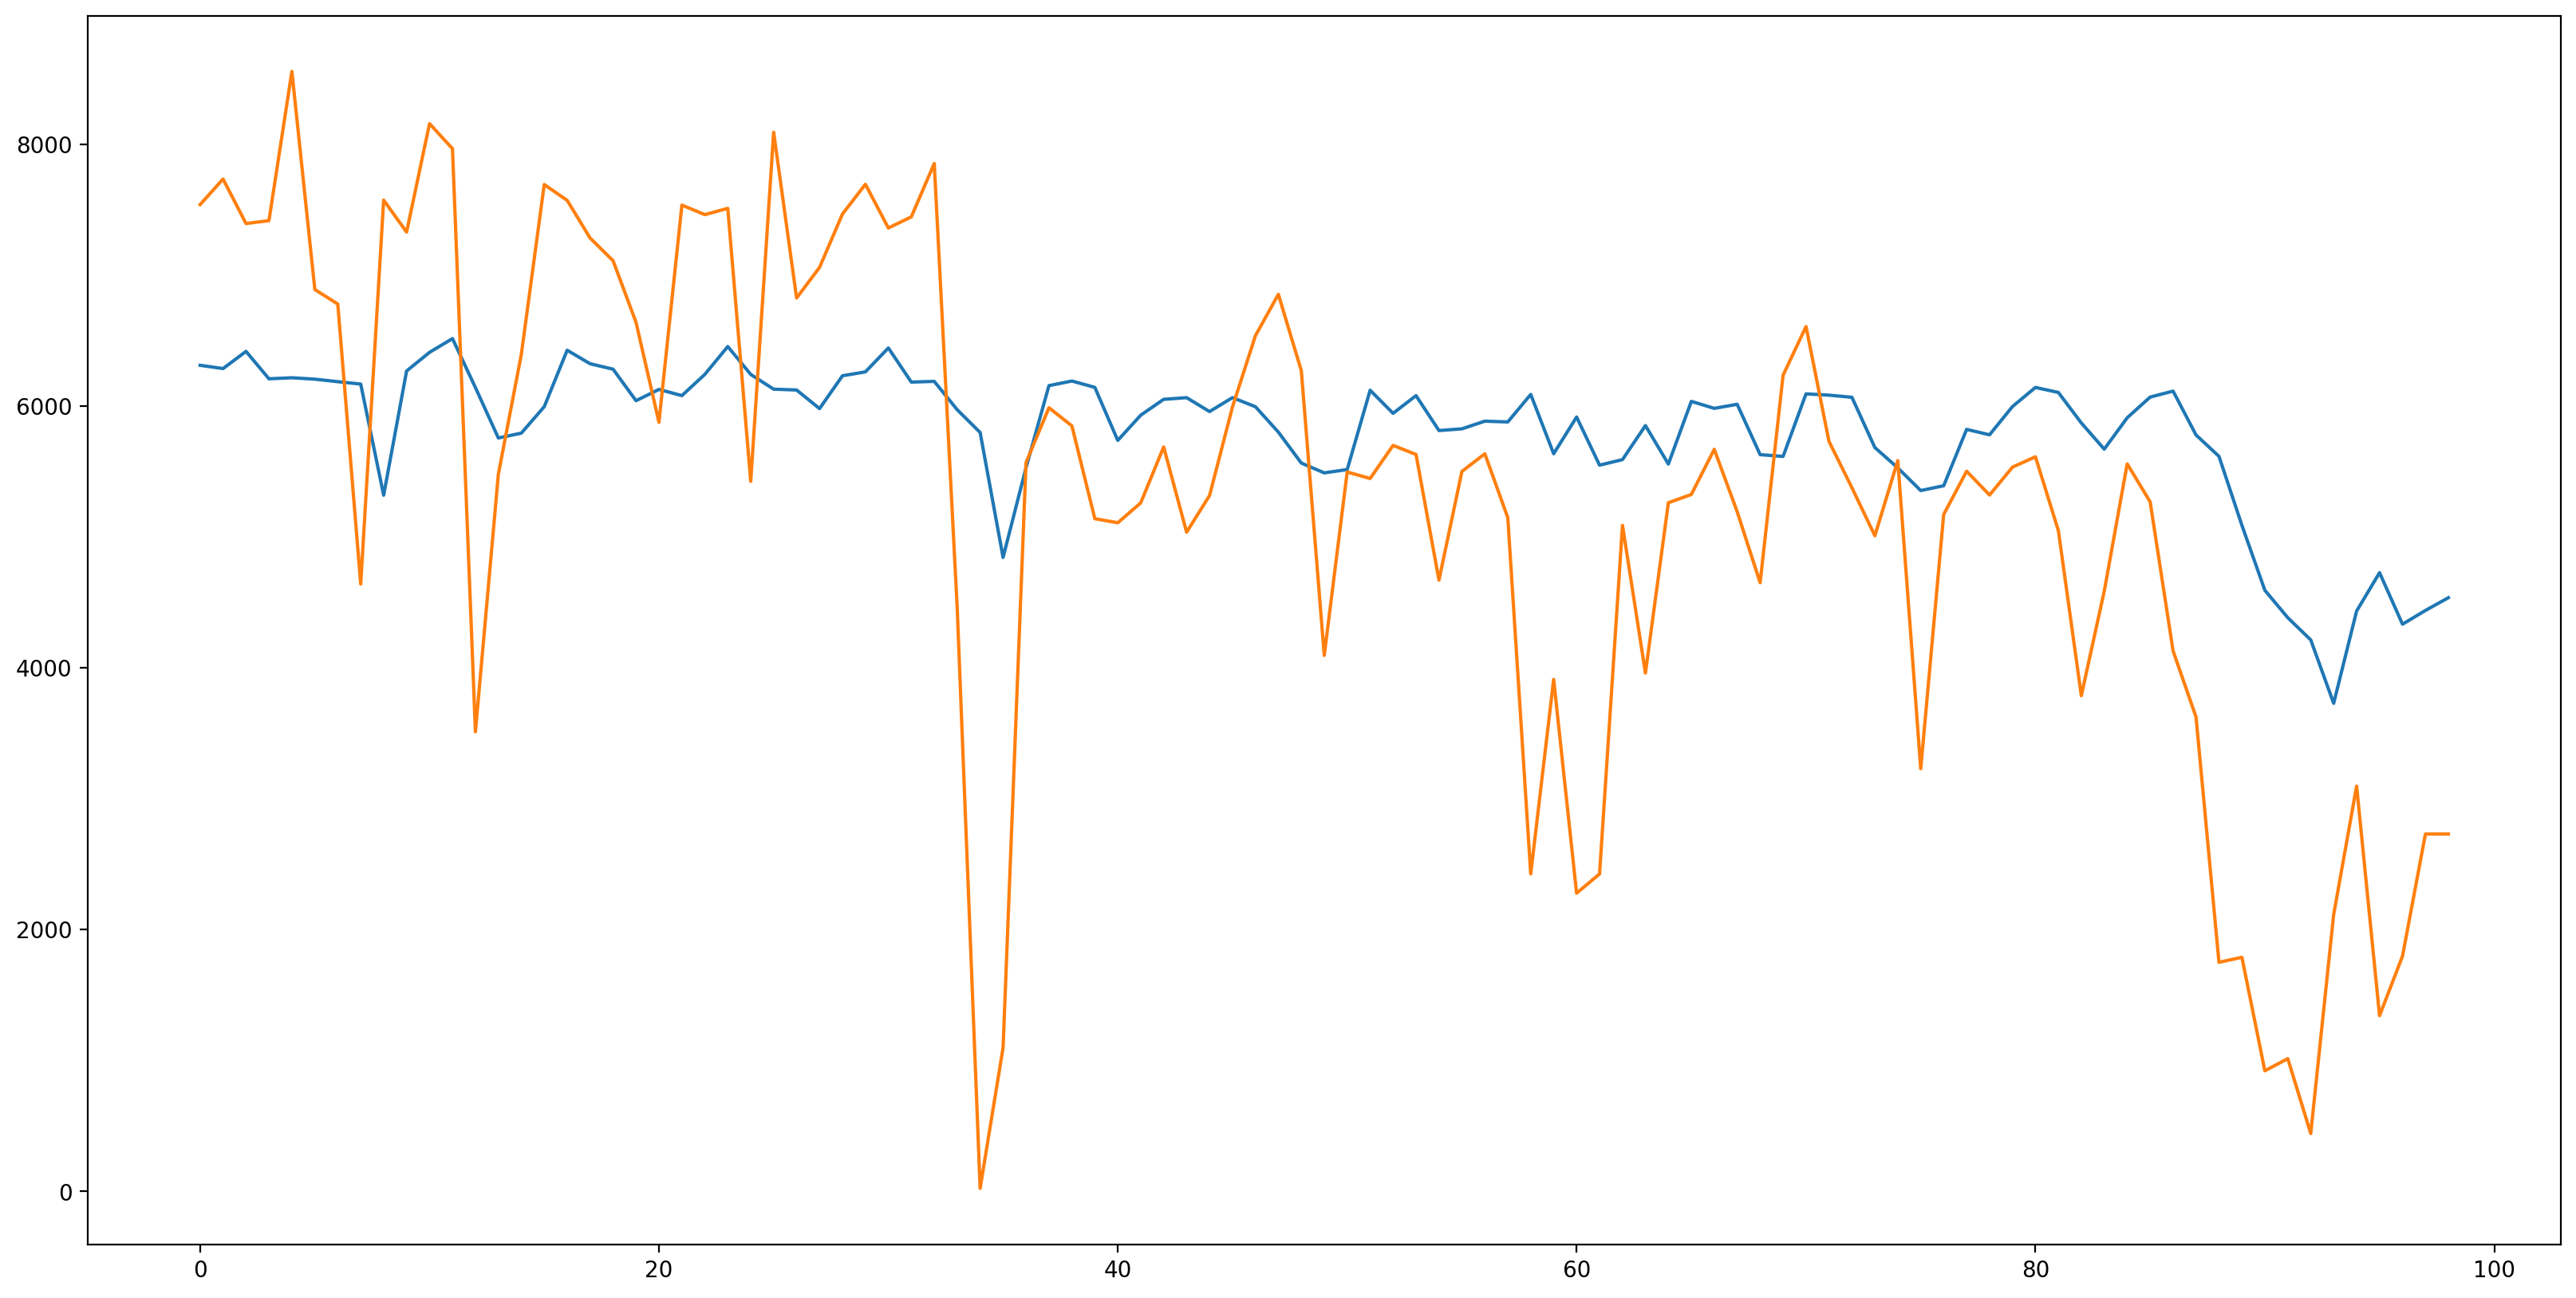

Saving...
Iter:  11 train:  0.11567343826952232 val:  0.18740590701576199
Iter time:  5.9060000000172295
Iter:  12 train:  0.11264755046133147 val:  0.2038421083809733
Iter time:  5.202999999979511
Iter:  13 train:  0.13309102435248055 val:  0.24125208712523785
Iter time:  5.39100000000326
Iter:  14 train:  0.126321738584584 val:  0.20316526499055623
Iter time:  5.453000000008615
Saving...
Iter:  15 train:  0.14756429135307791 val:  0.18361498293649567
Iter time:  5.452999999979511
Saving...
Iter:  16 train:  0.12066917576727423 val:  0.17584703142573835
Iter time:  6.328000000008615
Iter:  17 train:  0.12212586770485408 val:  0.18587119977623218
Iter time:  5.14100000000326
Iter:  18 train:  0.10900543659143107 val:  0.18216775978226332
Iter time:  6.453000000008615
Iter:  19 train:  0.11905433764410549 val:  0.1873011989125789
Iter time:  5.467999999993481
Iter:  20 train:  0.11270794190279435 val:  0.1885302063459663
Iter time:  6.0939999999827705
mse:  2438581.2 mae:  1130.378


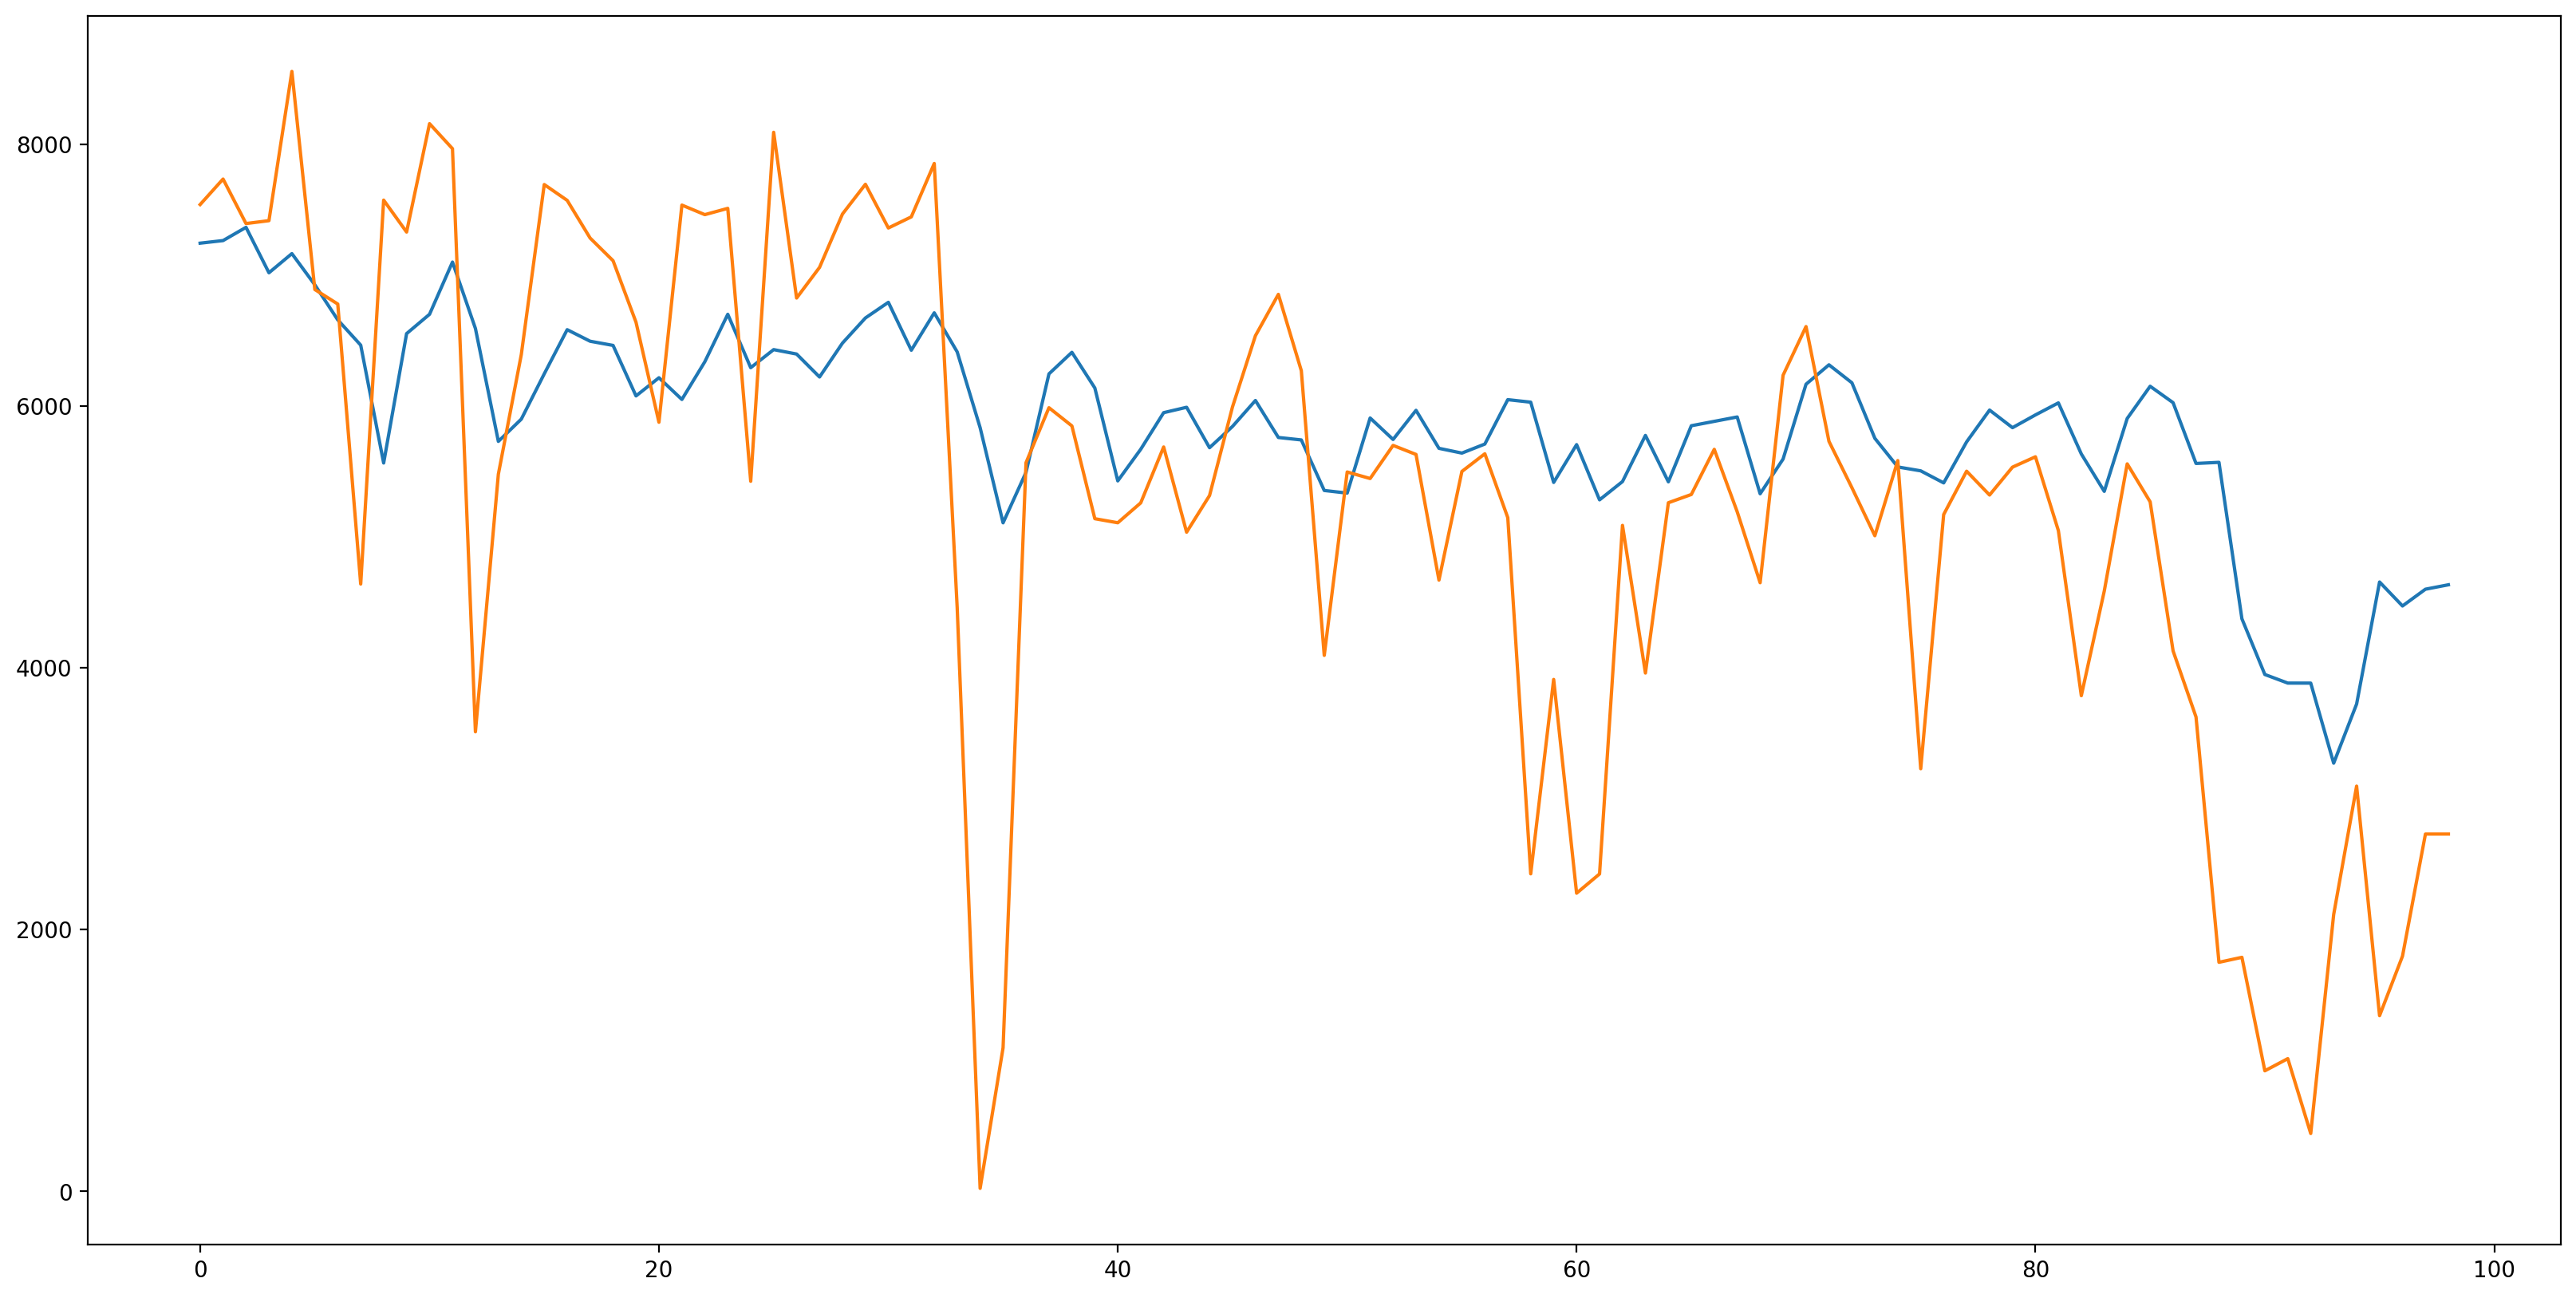

Iter:  21 train:  0.10834234504630756 val:  0.17983134829469255
Iter time:  6.3439999999827705
Iter:  22 train:  0.1102707149583934 val:  0.17773811510744883
Iter time:  5.171999999991385
Iter:  23 train:  0.1062179415676811 val:  0.1783546235493398
Iter time:  6.5310000000172295
Iter:  24 train:  0.10101320101532356 val:  0.1809000034382691
Iter time:  5.171999999991385
Saving...
Iter:  25 train:  0.1049656638313165 val:  0.16695836885966317
Iter time:  6.14100000000326
Iter:  26 train:  0.1200000931992508 val:  0.21273736531645093
Iter time:  5.85899999999674
Iter:  27 train:  0.10561950676903453 val:  0.18179520369990473
Iter time:  5.6560000000172295
Iter:  28 train:  0.10601856927950165 val:  0.19110672409460078
Iter time:  6.530999999988126
Saving...
Iter:  29 train:  0.10684571854722041 val:  0.1606314709060741
Iter time:  5.219000000011874
Iter:  30 train:  0.10315546436661045 val:  0.1952506366204722
Iter time:  6.577999999979511
mse:  2615533.5 mae:  1159.1353


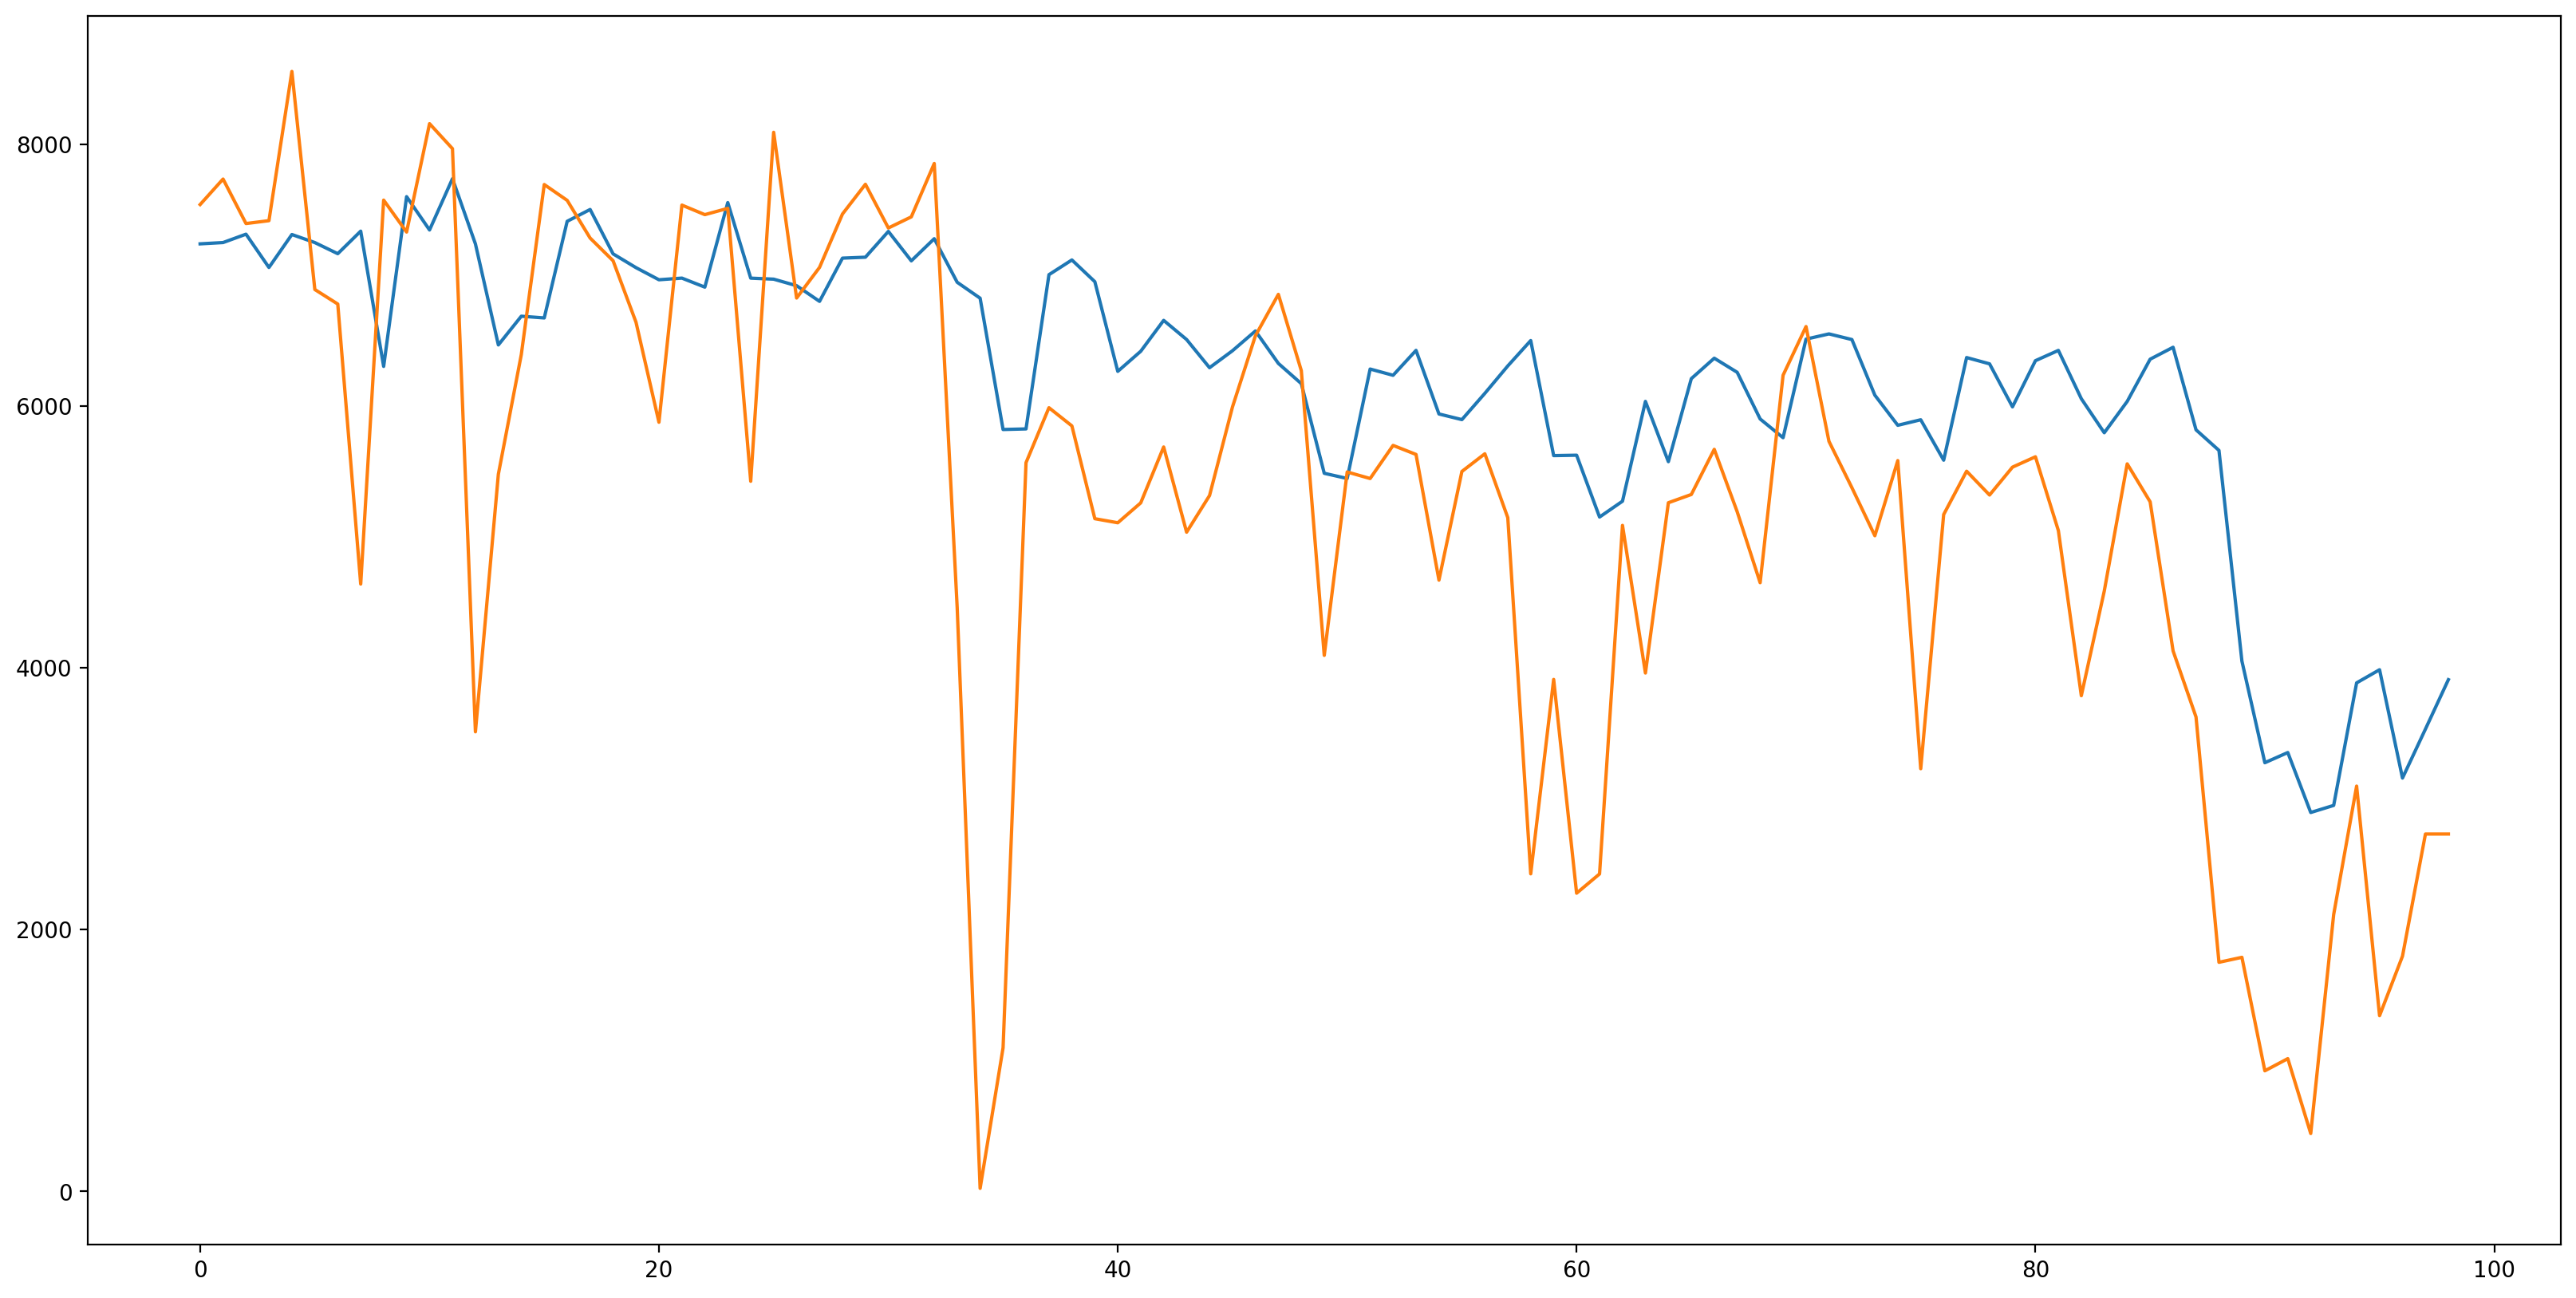

Iter:  31 train:  0.10092554921516 val:  0.17498888692233563
Iter time:  6.703000000008615
Iter:  32 train:  0.10015826527767757 val:  0.2317295946558284
Iter time:  5.405999999988126
Iter:  33 train:  0.10735521280623346 val:  0.2312085520752369
Iter time:  6.5
Iter:  34 train:  0.10790257622271109 val:  0.18750142410910323
Iter time:  5.2810000000172295
Iter:  35 train:  0.10423893031768185 val:  0.19163328387838743
Iter time:  7.0
Iter:  36 train:  0.11177603833021107 val:  0.19457456942749665
Iter time:  6.8439999999827705
Iter:  37 train:  0.10481995563060625 val:  0.20294512558627156
Iter time:  5.75
Iter:  38 train:  0.10925036087268537 val:  0.18729860718285724
Iter time:  6.6560000000172295
Iter:  39 train:  0.10334872142809935 val:  0.19825500082998002
Iter time:  6.0939999999827705
Iter:  40 train:  0.10239826740766672 val:  0.18502489853621887
Iter time:  6.094000000011874
mse:  2348744.0 mae:  1088.2593


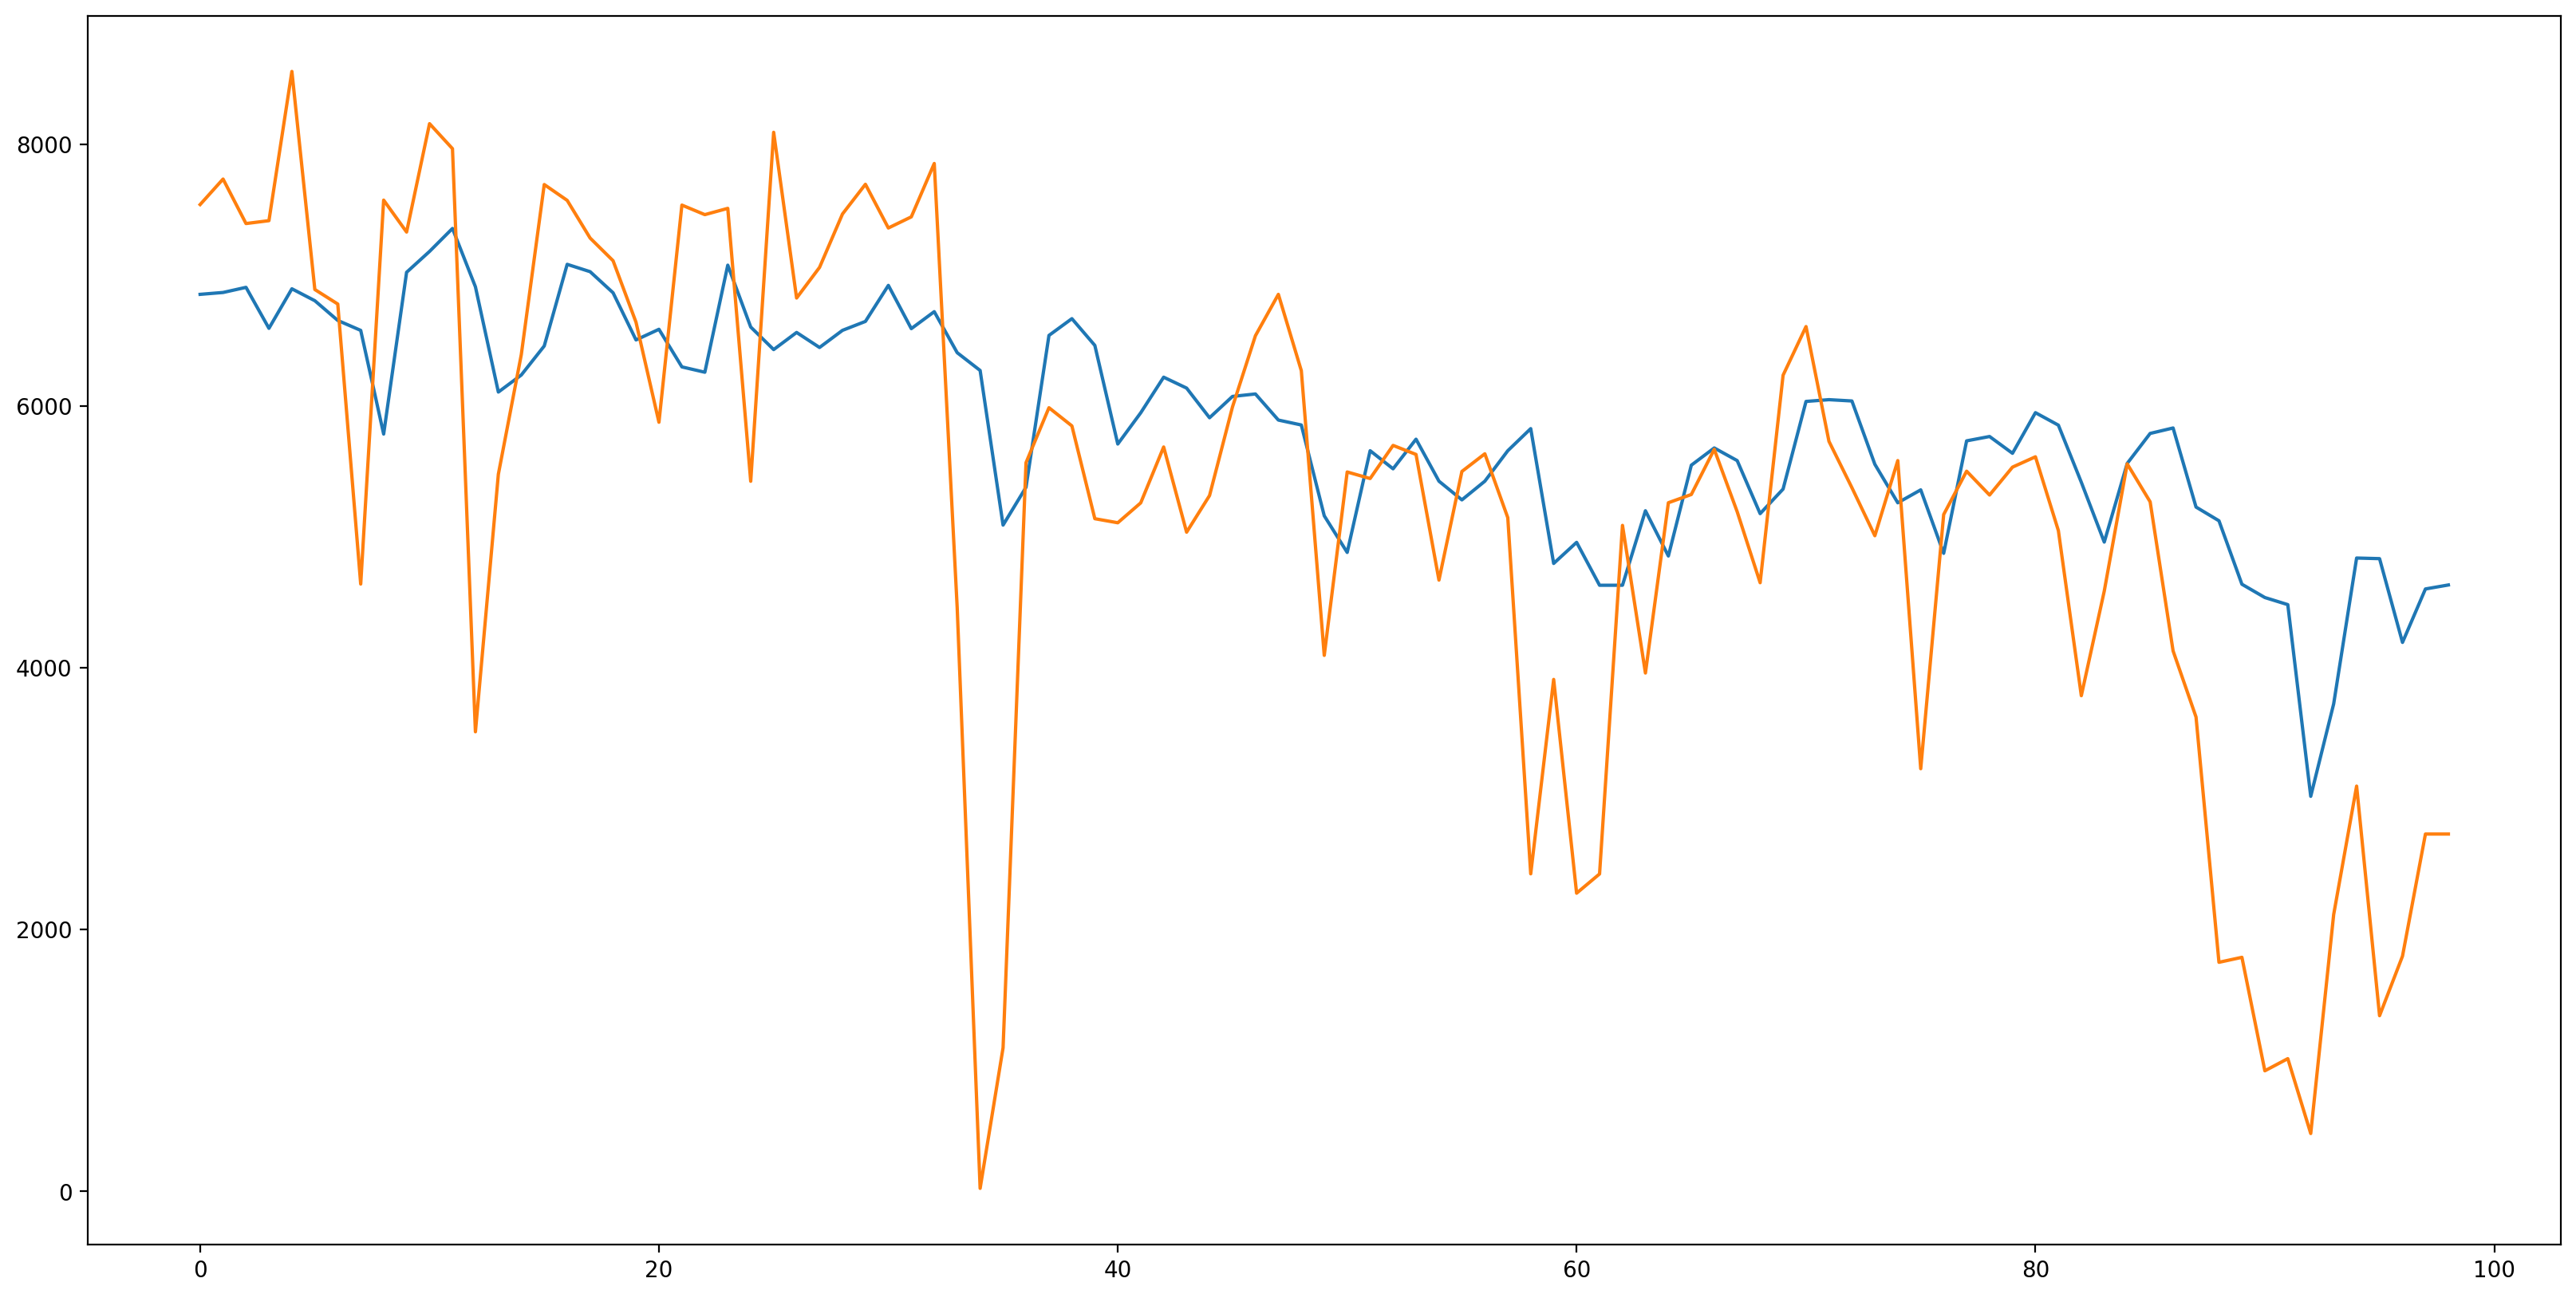

Iter:  41 train:  0.10108508005978888 val:  0.1849323491601011
Iter time:  7.062999999994645
Iter:  42 train:  0.10382710987615366 val:  0.19067557383721576
Iter time:  6.0310000000172295
Iter:  43 train:  0.10357059494263501 val:  0.17152319997442733
Iter time:  6.14100000000326
Iter:  44 train:  0.10201771210148892 val:  0.17365453039572964
Iter time:  5.530999999988126
Iter:  45 train:  0.1018156639699729 val:  0.18689057743851936
Iter time:  5.1560000000172295
Iter:  46 train:  0.10217785247988617 val:  0.18654424128293215
Iter time:  5.0
Iter:  47 train:  0.10563095537098262 val:  0.1840164716181528
Iter time:  5.015999999974156
Iter:  48 train:  0.10342141951804129 val:  0.19820724376643692
Iter time:  5.0310000000172295
Iter:  49 train:  0.09796270422971906 val:  0.2026419737441912
Iter time:  5.3439999999827705
Iter:  50 train:  0.1102361528059626 val:  0.1698231719335395
Iter time:  5.422000000020489
mse:  1978651.5 mae:  1073.3253


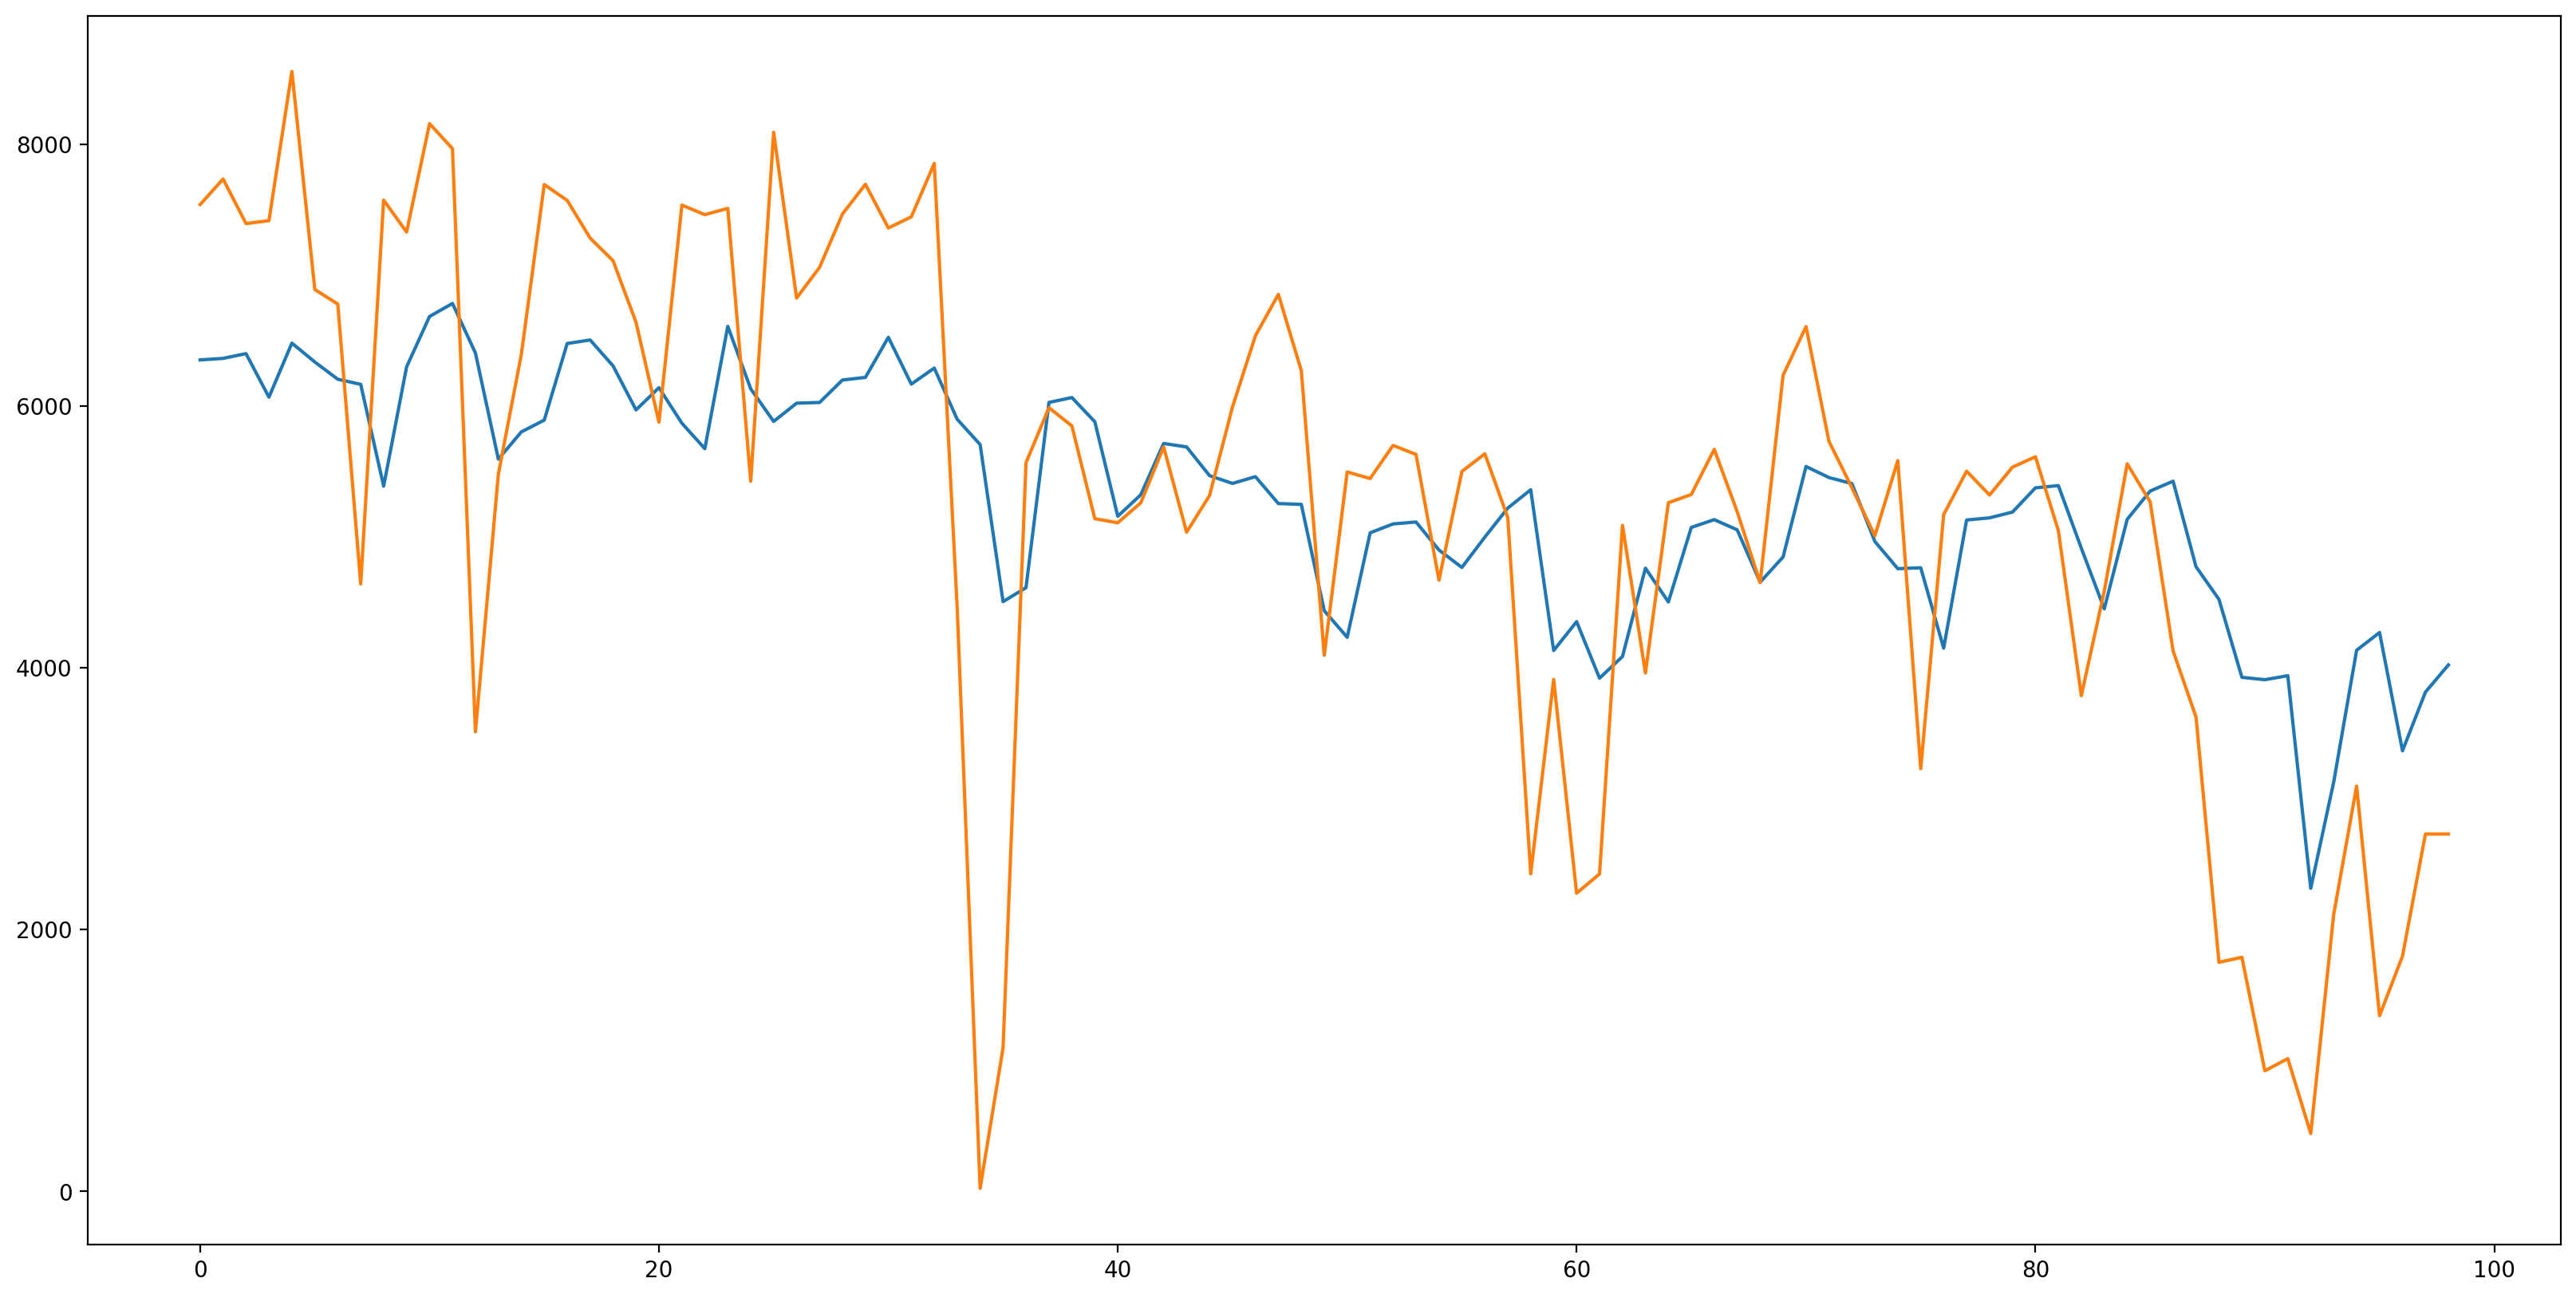

Iter:  51 train:  0.10887183529547811 val:  0.17681830259035147
Iter time:  5.780999999988126
Iter:  52 train:  0.10184240916297842 val:  0.17254242538427547
Iter time:  4.985000000015134
Iter:  53 train:  0.09862535191069242 val:  0.2014383170932293
Iter time:  5.421999999991385
Iter:  54 train:  0.10416761940147341 val:  0.17872967821536315
Iter time:  5.077999999979511
Iter:  55 train:  0.09943209943997398 val:  0.17502664138700935
Iter time:  5.047000000020489
Iter:  56 train:  0.09961685234672145 val:  0.196906229215941
Iter time:  4.921999999991385
Iter:  57 train:  0.09895551162102682 val:  0.20776377062813367
Iter time:  5.01600000000326
Iter:  58 train:  0.09968505283470097 val:  0.18798260468158412
Iter time:  5.077999999979511
mse:  3300752.5 mae:  1348.6707


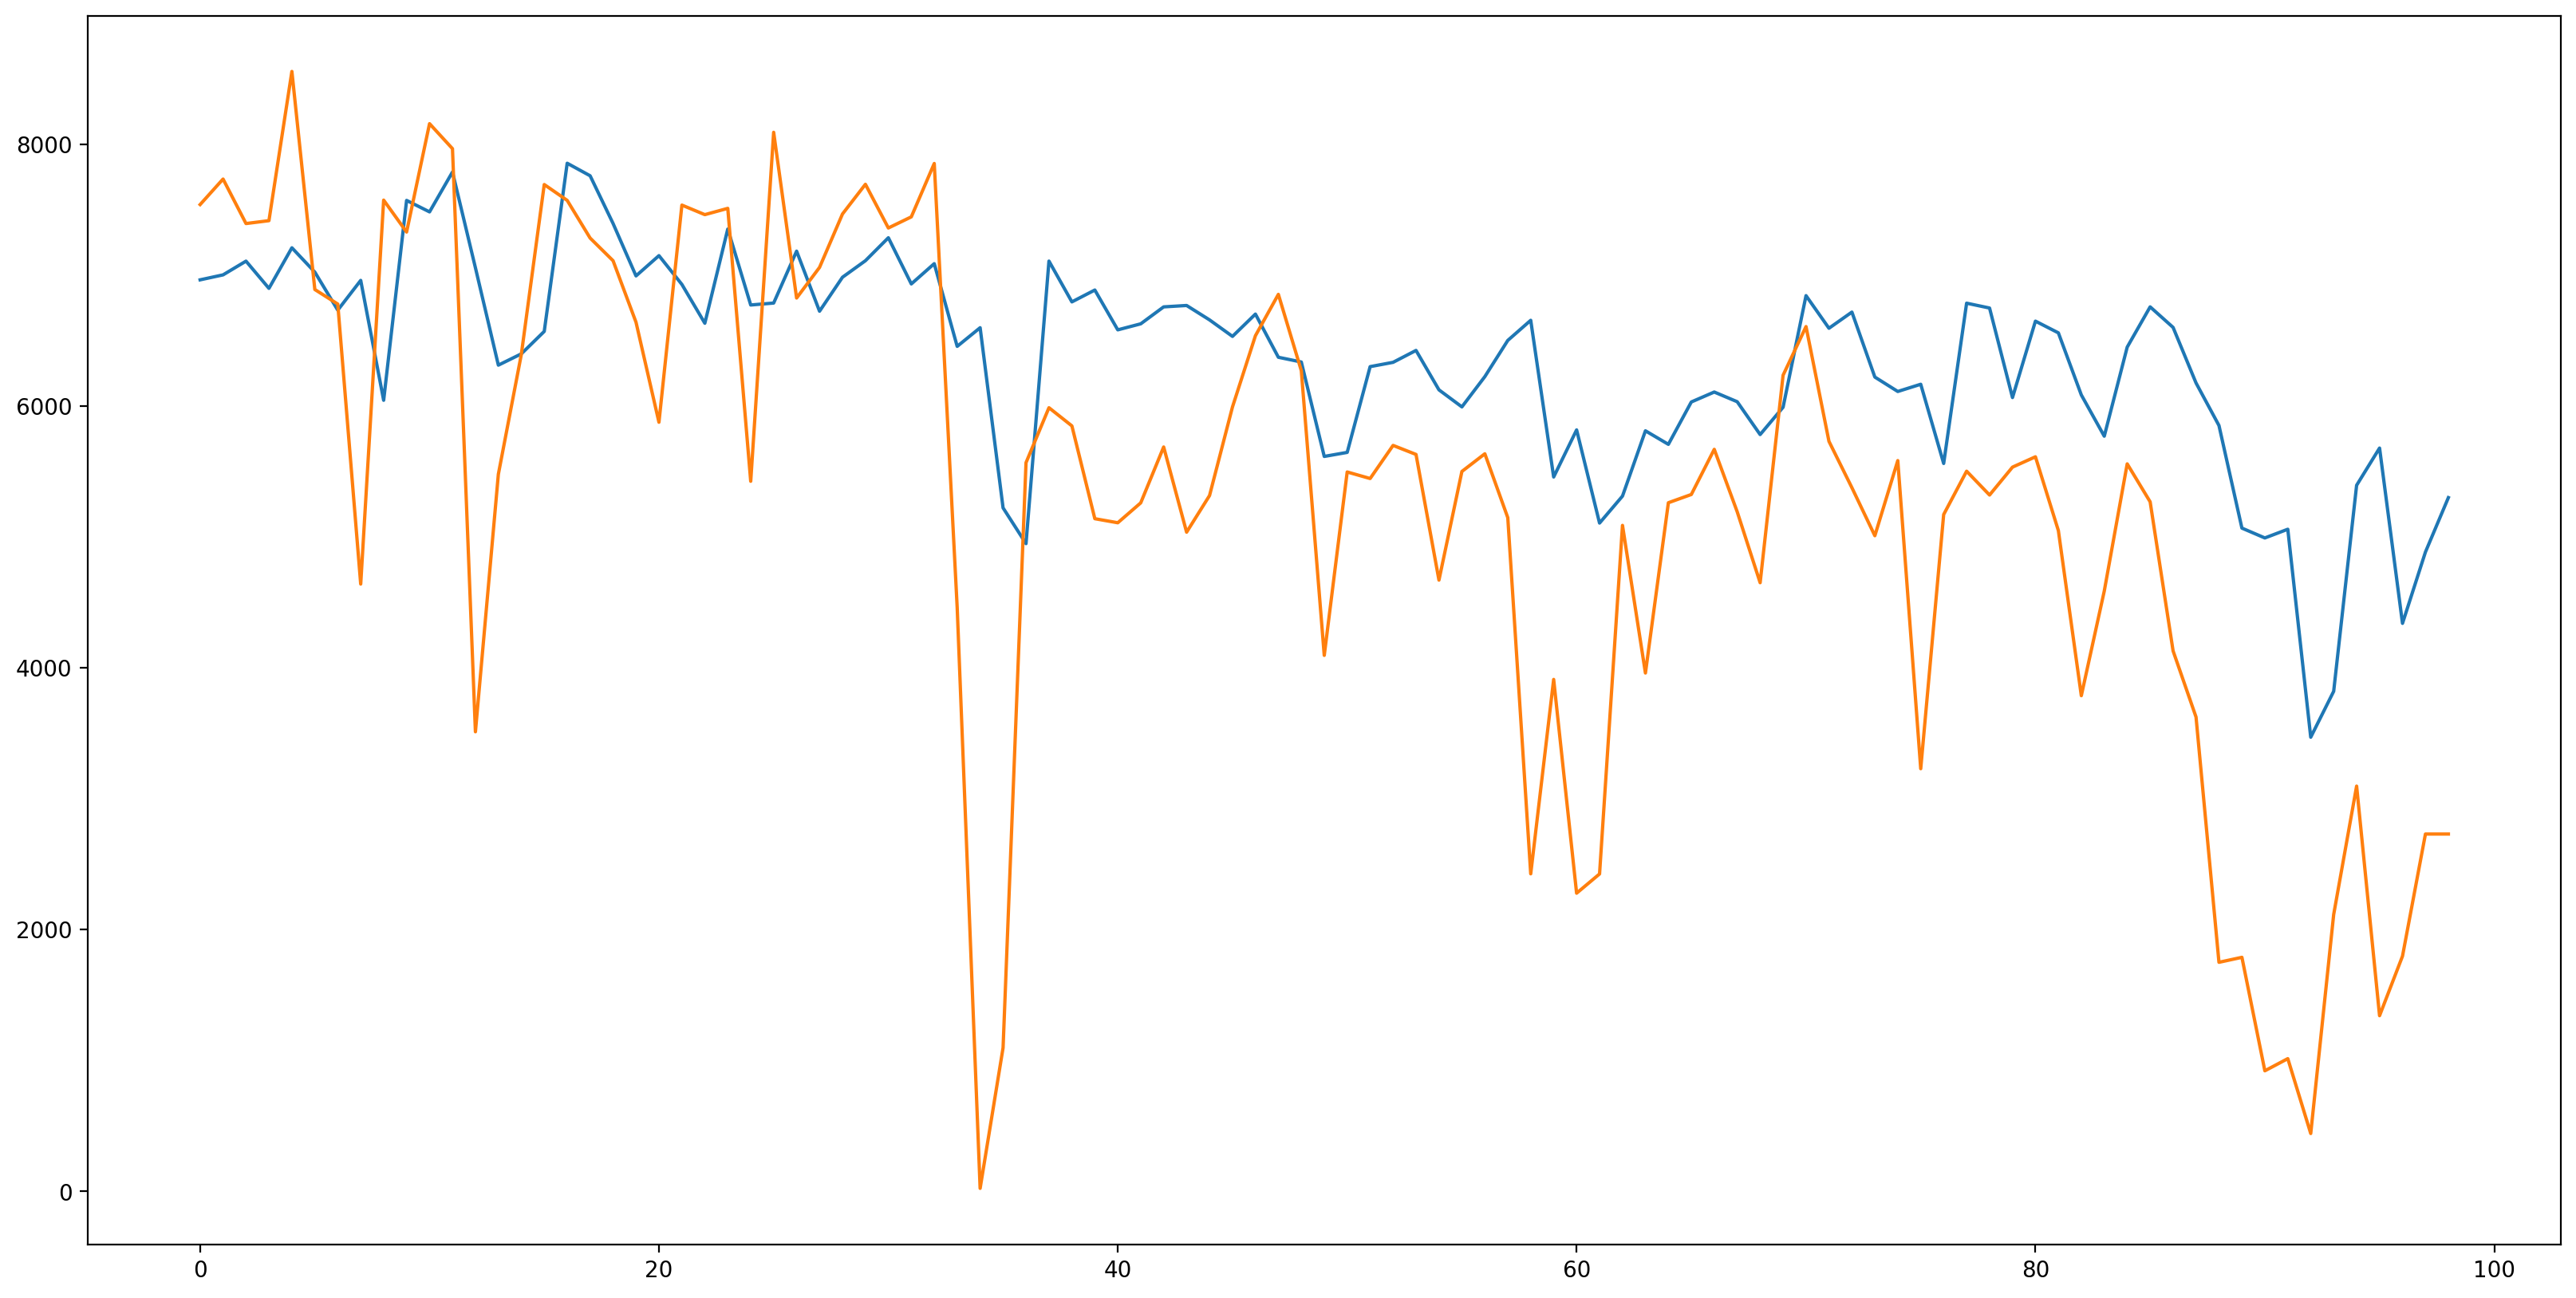

In [43]:
epochs = 10001
loss = nn.MSELoss()
patience = 30
min_val_loss = 9999
counter = 0
for i in tqdm(range(epochs)):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x
        batch_y = batch_y
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    #with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas = []
    betas = []
    
    for batch_x, batch_y in val_loader:
        batch_x = batch_x
        batch_y = batch_y
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas.append(a.detach().cpu().numpy())
        betas.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    alphas = np.concatenate(alphas)
    betas = np.concatenate(betas)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_full_lstm.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [35]:
alphas.shape, betas.shape

((99, 15, 27, 1), (99, 27, 1))

In [36]:
alphas = alphas.mean(axis=0)
betas = betas.mean(axis=0)

In [37]:
alphas = alphas[..., 0]
betas = betas[..., 0]

In [38]:
alphas = alphas.transpose(1, 0)

(15, 27)


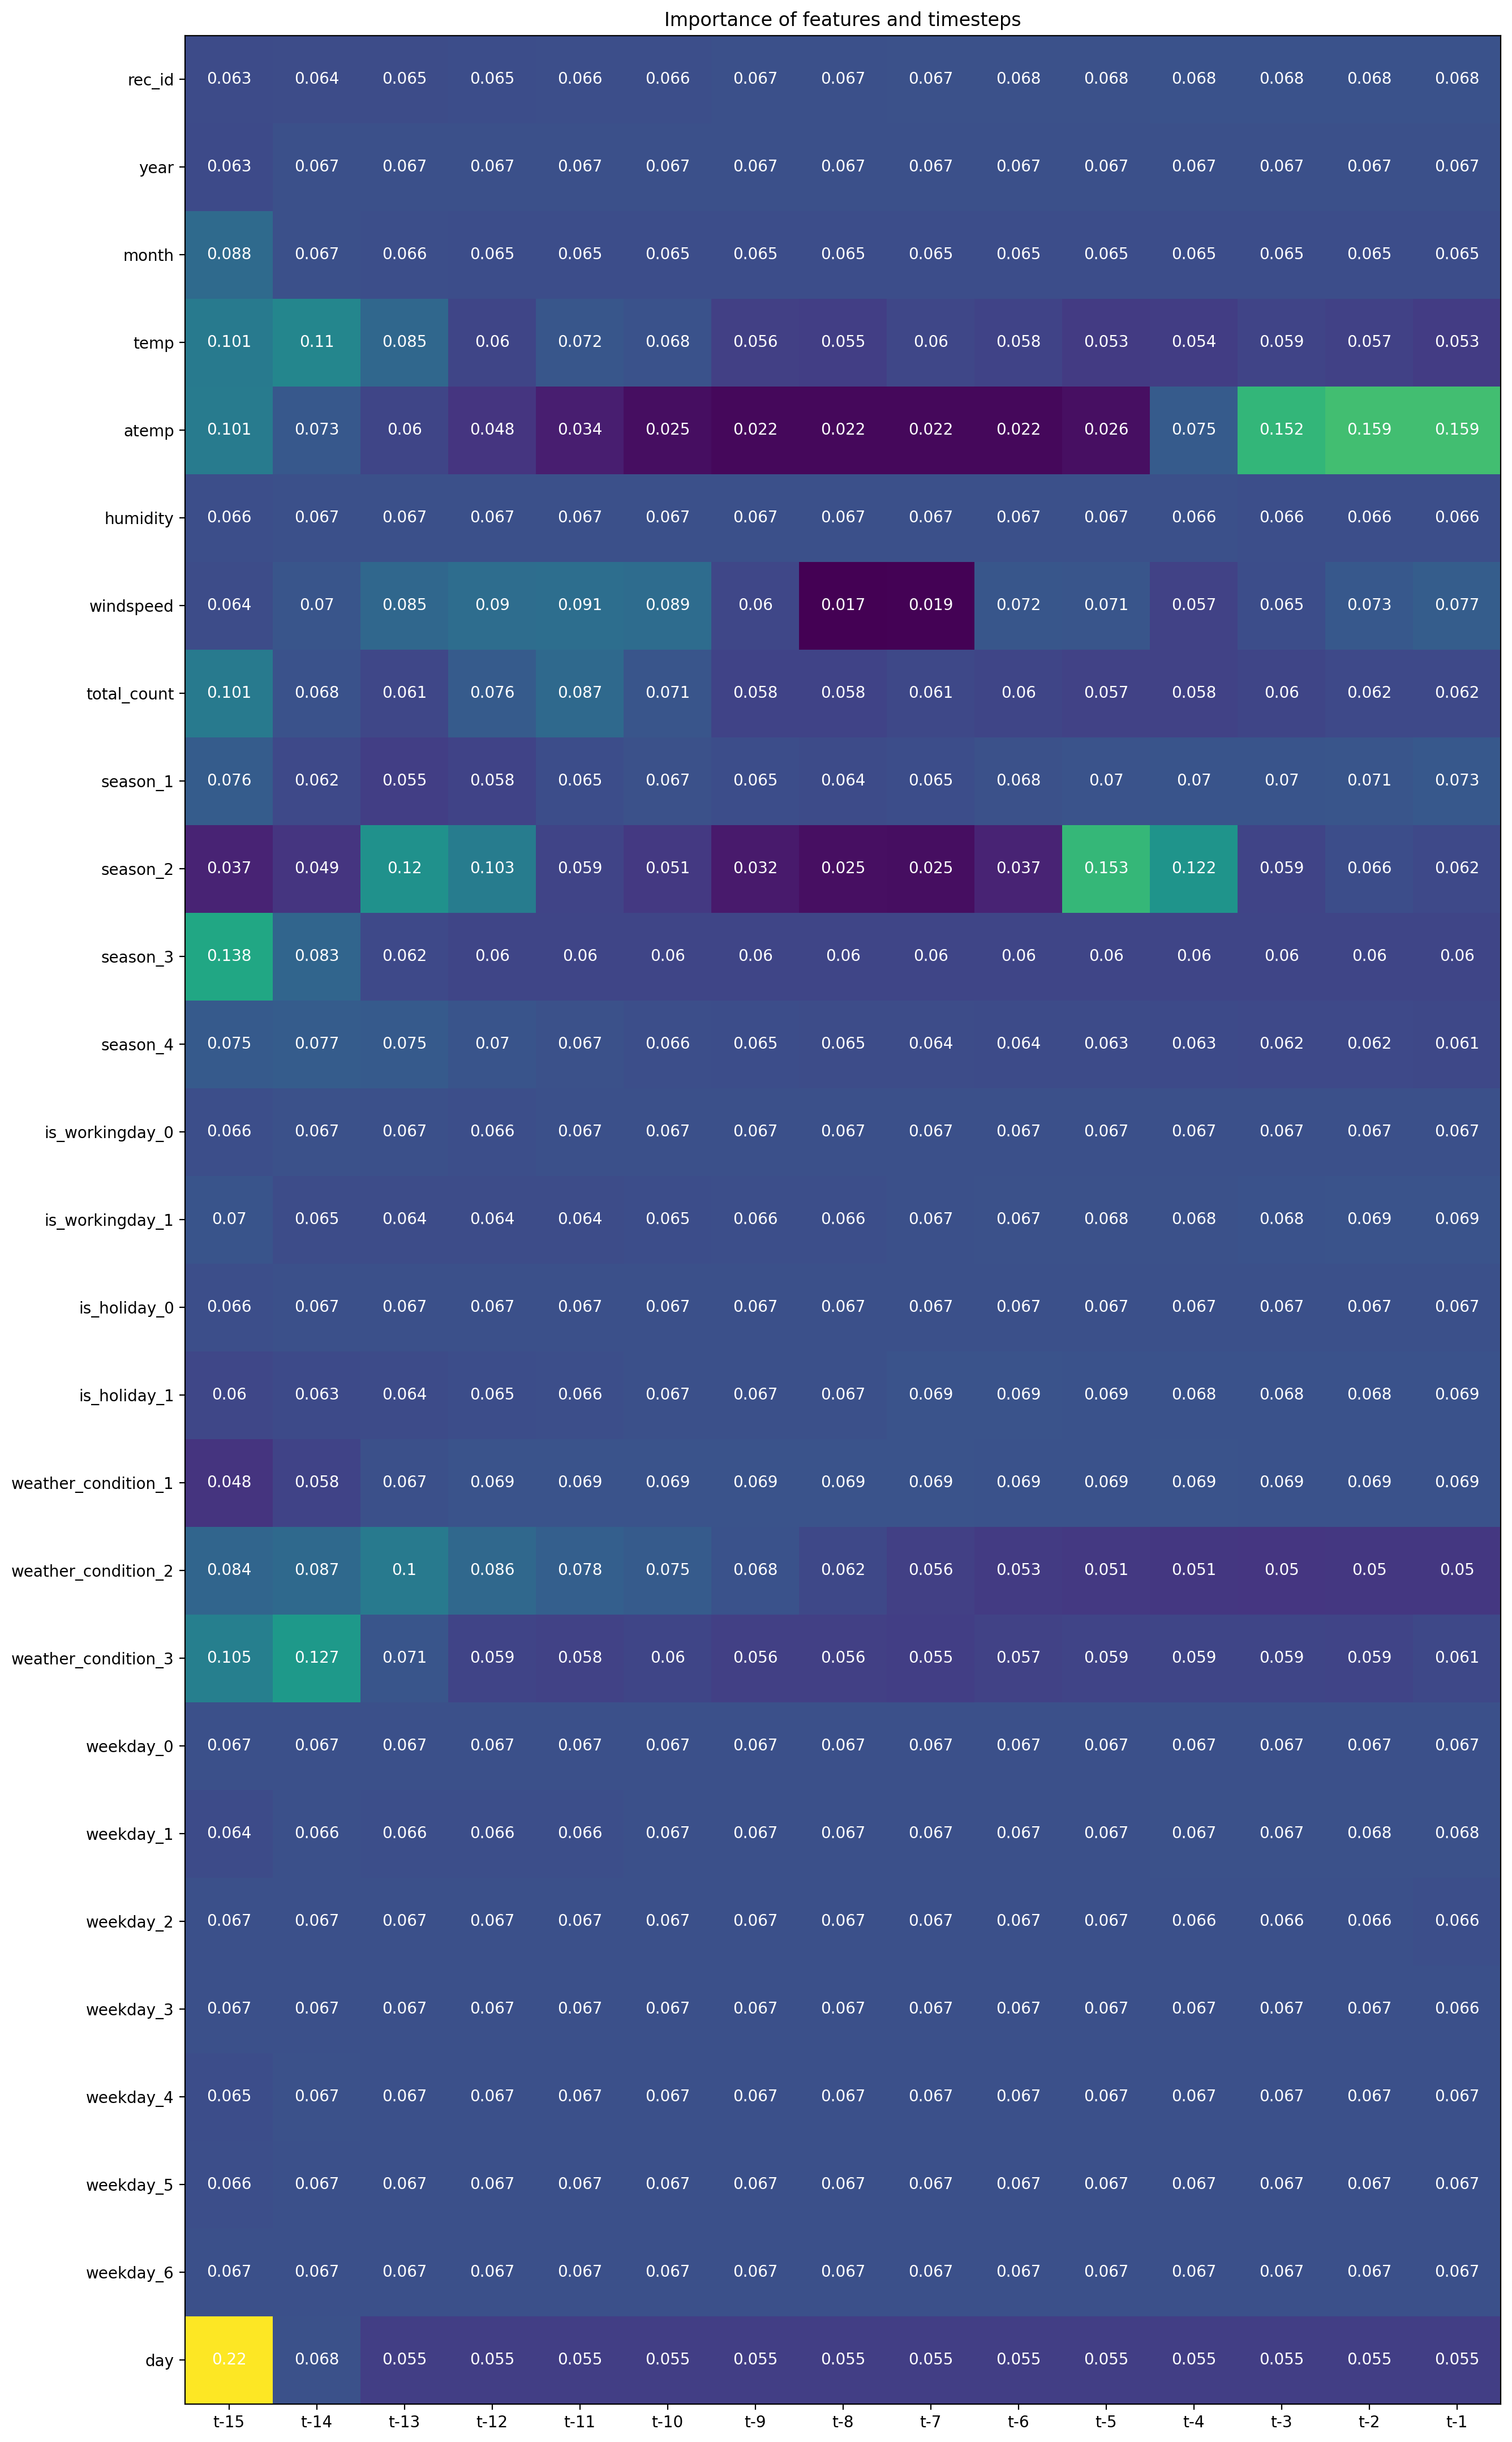

In [39]:
print(X_train[1].shape)
X_train_t = torch.Tensor(X_train)

fig, ax = plt.subplots(figsize=(15, 30))
im = ax.imshow(alphas)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], 0, -1)])
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Importance of features and timesteps")
#fig.tight_layout()
plt.show()

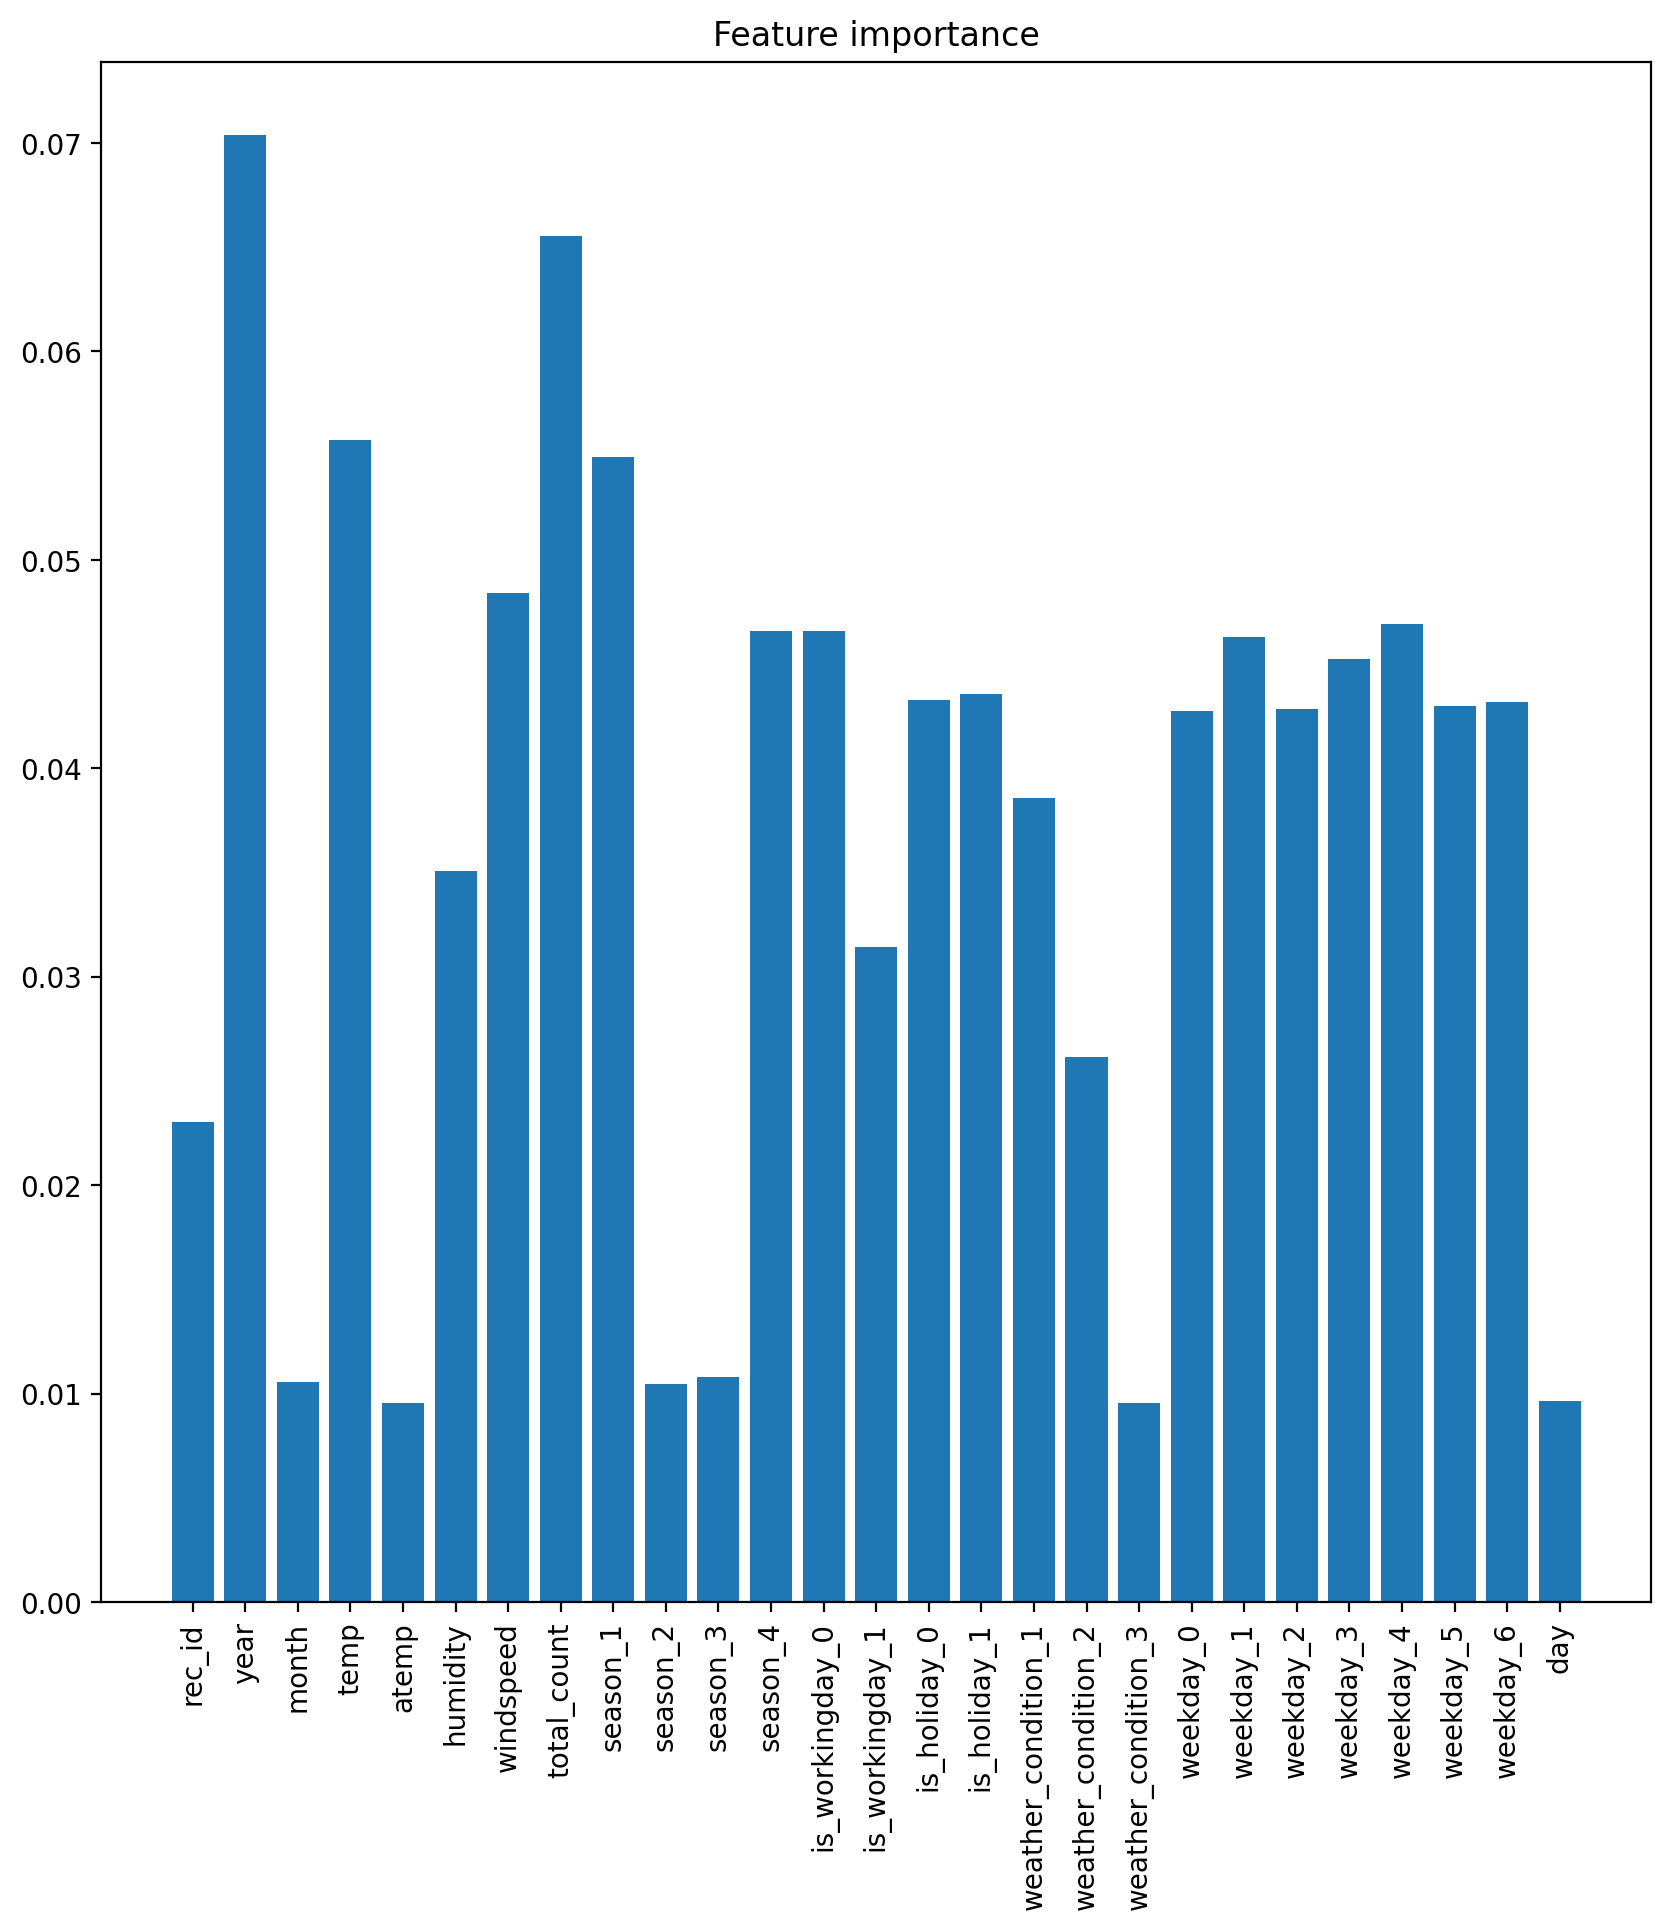

In [40]:
plt.figure(figsize=(10, 10))
plt.title("Feature importance")
plt.bar(range(len(cols)), betas)
plt.xticks(range(len(cols)), cols, rotation=90);